In [1]:
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, make_scorer

from sklearn.feature_selection import SequentialFeatureSelector, SelectFromModel

import matplotlib.pyplot as plt
from sklearn.svm import SVC
import pandas as pd
import numpy as np
from time import time
from copy import deepcopy



In [2]:
# load features labels
with open('human+activity+recognition+using+smartphones/UCI HAR Dataset/features.txt') as file:
    features_labels = [line.strip().split()[1] for line in file.readlines()]

# load target class labels
with open('human+activity+recognition+using+smartphones/UCI HAR Dataset/activity_labels.txt') as file:
    target_class_labels = [line.strip().split()[1] for line in file.readlines()]

# Load the train set from txt files
X_train_file_path = 'human+activity+recognition+using+smartphones/UCI HAR Dataset/train/X_train.txt'
y_train_file_path = 'human+activity+recognition+using+smartphones/UCI HAR Dataset/train/y_train.txt'
X_train = pd.read_csv(X_train_file_path, header=None, delim_whitespace=True)
X_train.columns = features_labels
y_train = pd.read_csv(y_train_file_path, header=None, delim_whitespace=True).squeeze('columns')
y_train.name = 'target_class'


# Load the test set from txt files
X_test_file_path = 'human+activity+recognition+using+smartphones/UCI HAR Dataset/test/X_test.txt'
y_test_file_path = 'human+activity+recognition+using+smartphones/UCI HAR Dataset/test/y_test.txt'
X_test = pd.read_csv(X_test_file_path, header=None, delim_whitespace=True)
X_test.columns = features_labels
y_test = pd.read_csv(y_test_file_path, header=None, delim_whitespace=True).squeeze("columns")
y_test.name = 'target_class'


# creation of a report dataframe
report_series = list()
timings_series = list()

In [3]:
# counts in each class 
pd.concat([pd.DataFrame(target_class_labels, columns=['activity_label'], index=range(1,7)),
           y_train.value_counts().sort_index()], axis=1).rename(columns={'target_class':'counts'})

,activity_label,counts
1,WALKING,1226
2,WALKING_UPSTAIRS,1073
3,WALKING_DOWNSTAIRS,986
4,SITTING,1286
5,STANDING,1374
6,LAYING,1407


In [4]:
# checking for missing values
X_train.columns[X_train[X_train.isna()].any()]

Index([], dtype='object')

Text(0, 0.5, 'frequency')

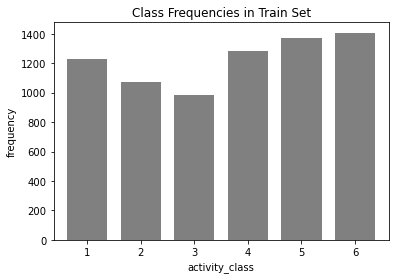

In [5]:
y_train.value_counts().sort_index().plot(kind='bar', color='grey', rot=0, title='Class Frequencies in Train Set', width=0.75)
plt.xlabel('activity_class')
plt.ylabel('frequency')


In [6]:
# initialization of models
models = [('svm_model', SVC(C=1, kernel='linear', gamma='auto'))]
models_pca = [(model_name + '_pca', model) for model_name, model in deepcopy(models)]
selectors_wrapping_models = [(model_name + "_wrapping_seq",
                              SequentialFeatureSelector(estimator=model,
                                                        direction='forward',
                                                        n_features_to_select='auto',
                                                        tol= 0.0003,
                                                        scoring=make_scorer(balanced_accuracy_score),
                                                        n_jobs=-1), 
                              model) for model_name, model in deepcopy(models)]
selectors_embedding_models = [(model_name + "_embedding_select",
                              SelectFromModel(model, threshold='median'), 
                              model) for model_name, model in deepcopy(models)]

In [7]:
for model_name, model in models:
    start_time_train = time()
    model.fit(X_train, y_train)
    end_time_train = time()
    
    start_time_test = time()
    y_pred = model.predict(X=X_test)
    end_time_test = time()
    metrics = {
        'accuracy': accuracy_score(y_true=y_test, y_pred=y_pred),
        'balanced_accuracy': balanced_accuracy_score(y_true=y_test, y_pred=y_pred),
        'f1_score': f1_score(y_true=y_test, y_pred=y_pred, average='macro'),
        'precision': precision_score(y_true=y_test, y_pred=y_pred, average='macro'),
        'training_time':end_time_train - start_time_train,
        'predicting_time':end_time_test - start_time_test
               }
    report_series.append(pd.Series(data=metrics, name=model_name))
    


In [8]:
pd.DataFrame(report_series)

,accuracy,balanced_accuracy,f1_score,precision,training_time,predicting_time
svm_model,0.964031,0.963589,0.964198,0.965895,0.399614,0.243624


In [9]:
# Create a PCA object
pca = PCA()

# Fit the PCA object on the data
pca.fit(X_train)

# Get the explained variance ratios
explained_variance_ratio = pca.explained_variance_ratio_

# Create a cumulative sum of the explained variance ratios
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

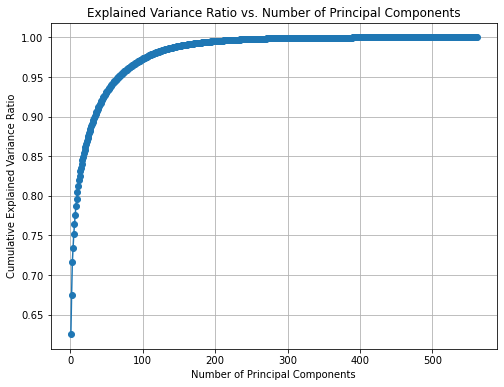

In [10]:
# Extract the values from the dictionary
n_values = list(range(1, X_train.shape[1] + 1))
explained_variance_ratios = list(cumulative_explained_variance)

# Plotting the cumulative explained variance ratio
plt.figure(figsize=(8, 6))
plt.plot(n_values, explained_variance_ratios, marker='o', linestyle='-')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')

plt.title('Explained Variance Ratio vs. Number of Principal Components')
plt.grid(True)
plt.show()

In [11]:
# Calculate the cumulative sum of the explained variance ratios
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Find the number of components needed to explain more than 0.9 variance
n_components = np.where(cumulative_explained_variance > 0.9)[0][0] + 1

# initialize the prefered pca

pca_selector = PCA(n_components=n_components)

# Transform the data into the new reduced dimensional space
transformed_data = pca_selector.fit_transform(X_train)



print("Original data shape:", X_train.shape)
print("Transformed data shape:", transformed_data.shape)
print("Explained variance ratio:", explained_variance_ratio[:n_components])
print("Sum of ratio is:", cumulative_explained_variance[n_components-1])
print('------------------------------------------')
    

Original data shape: (7352, 561)
Transformed data shape: (7352, 34)
Explained variance ratio: [0.6255444  0.04913023 0.04121467 0.01874956 0.0169486  0.01272069
 0.01176685 0.01068973 0.0096938  0.00858018 0.00762302 0.00672446
 0.0057942  0.00557881 0.00498926 0.00474938 0.004672   0.00431618
 0.00425715 0.00410395 0.00394002 0.00375309 0.00352427 0.00339359
 0.00332139 0.00319429 0.00301779 0.00291783 0.0028957  0.00281928
 0.00276704 0.00263395 0.00255307 0.00235866]
Sum of ratio is: 0.9009370881393087
------------------------------------------


In [12]:
# deployment and training with transormed data
for model_name, model_pca in models_pca:
    start_time_train = time()
    model_pca.fit(transformed_data, y_train)
    end_time_train = time()
    x_test_tranformed = pca_selector.transform(X=X_test)
    
    start_time_test = time()
    y_pred = model_pca.predict(x_test_tranformed)
    end_time_test = time()
    
    metrics = {
        'accuracy': accuracy_score(y_true=y_test, y_pred=y_pred),
        'balanced_accuracy': balanced_accuracy_score(y_true=y_test, y_pred=y_pred),
        'f1_score': f1_score(y_true=y_test, y_pred=y_pred, average='macro'),
        'precision': precision_score(y_true=y_test, y_pred=y_pred, average='macro'),
        'training_time':end_time_train - start_time_train,
        'predicting_time':end_time_test - start_time_test
               }
    report_series.append(pd.Series(data=metrics, name=model_name))

In [13]:
pd.DataFrame(report_series)

,accuracy,balanced_accuracy,f1_score,precision,training_time,predicting_time
svm_model,0.964031,0.963589,0.964198,0.965895,0.399614,0.243624
svm_model_pca,0.907363,0.904144,0.904770,0.906374,0.139555,0.060524


In [14]:
for model_name, selector, model_wrapping in selectors_wrapping_models:
    transformed_x_train = selector.fit_transform(X_train, y_train)
    transformed_x_test = selector.transform(X_test)

    start_time_train = time()
    model_wrapping.fit(transformed_x_train, y_train)
    end_time_train = time()
    
    
    start_time_test = time()
    y_pred = model_wrapping.predict(transformed_x_test)
    end_time_test = time()
    
    metrics = {
        'accuracy': accuracy_score(y_true=y_test, y_pred=y_pred),
        'balanced_accuracy': balanced_accuracy_score(y_true=y_test, y_pred=y_pred),
        'f1_score': f1_score(y_true=y_test, y_pred=y_pred, average='macro'),
        'precision': precision_score(y_true=y_test, y_pred=y_pred, average='macro'),
        'training_time':end_time_train - start_time_train,
        'predicting_time':end_time_test - start_time_test
               }
    report_series.append(pd.Series(data=metrics, name=model_name))

In [15]:
pd.DataFrame(report_series)

,accuracy,balanced_accuracy,f1_score,precision,training_time,predicting_time
svm_model,0.964031,0.963589,0.964198,0.965895,0.399614,0.243624
svm_model_pca,0.907363,0.904144,0.904770,0.906374,0.139555,0.060524
svm_model_wrapping_seq,0.929420,0.927174,0.928259,0.932157,0.080174,0.059594


In [16]:
for model_name, selector, model_wrapping in selectors_wrapping_models:
    print(f"Selected {X_test.columns[selector.get_support()].shape[0]} features for {model_name}:")
    print(X_test.columns[selector.get_support()])
    

Selected 24 features for svm_model_wrapping_seq:
Index(['tBodyAcc-arCoeff()-Y,1', 'tBodyAcc-correlation()-X,Y',
       'tGravityAcc-min()-X', 'tGravityAcc-arCoeff()-X,2',
       'tGravityAcc-arCoeff()-Y,1', 'tGravityAcc-arCoeff()-Y,2',
       'tBodyAccJerk-entropy()-Y', 'tBodyAccJerk-arCoeff()-Z,3',
       'tBodyAccJerk-correlation()-X,Y', 'tBodyGyro-entropy()-X',
       'tBodyGyro-arCoeff()-X,1', 'tBodyGyro-arCoeff()-X,2',
       'tBodyGyro-arCoeff()-Y,4', 'tBodyGyroJerk-entropy()-X',
       'tBodyGyroJerk-arCoeff()-X,1', 'tBodyGyroJerk-correlation()-X,Z',
       'tBodyAccMag-mean()', 'tBodyGyroJerkMag-entropy()', 'fBodyAcc-max()-X',
       'fBodyAcc-maxInds-Y', 'fBodyAccJerk-iqr()-Z', 'fBodyGyro-max()-Z',
       'fBodyAccMag-energy()', 'angle(Y,gravityMean)'],
      dtype='object')


In [17]:
for model_name, selector, model_wrapping in selectors_embedding_models:
    transformed_x_train = selector.fit_transform(X_train, y_train)
    transformed_x_test = selector.transform(X_test)

    start_time_train = time()
    model_wrapping.fit(transformed_x_train, y_train)
    end_time_train = time()
    
    
    start_time_test = time()
    y_pred = model_wrapping.predict(transformed_x_test)
    end_time_test = time()
    
    metrics = {
        'accuracy': accuracy_score(y_true=y_test, y_pred=y_pred),
        'balanced_accuracy': balanced_accuracy_score(y_true=y_test, y_pred=y_pred),
        'f1_score': f1_score(y_true=y_test, y_pred=y_pred, average='macro'),
        'precision': precision_score(y_true=y_test, y_pred=y_pred, average='macro'),
        'training_time':end_time_train - start_time_train,
        'predicting_time':end_time_test - start_time_test
               }
    report_series.append(pd.Series(data=metrics, name=model_name))

In [18]:
pd.DataFrame(report_series)

,accuracy,balanced_accuracy,f1_score,precision,training_time,predicting_time
svm_model,0.964031,0.963589,0.964198,0.965895,0.399614,0.243624
svm_model_pca,0.907363,0.904144,0.904770,0.906374,0.139555,0.060524
svm_model_wrapping_seq,0.929420,0.927174,0.928259,0.932157,0.080174,0.059594
svm_model_embedding_select,0.964710,0.964113,0.964785,0.966628,0.213844,0.124033


In [19]:
for model_name, selector, model_wrapping in selectors_embedding_models:
    print(f"Selected {X_test.columns[selector.get_support()].shape[0]} features for {model_name}:")
    print(X_test.columns[selector.get_support()])

Selected 281 features for svm_model_embedding_select:
Index(['tBodyAcc-mean()-Z', 'tBodyAcc-std()-X', 'tBodyAcc-std()-Y',
       'tBodyAcc-mad()-X', 'tBodyAcc-max()-X', 'tBodyAcc-max()-Y',
       'tBodyAcc-max()-Z', 'tBodyAcc-min()-X', 'tBodyAcc-min()-Y',
       'tBodyAcc-min()-Z',
       ...
       'fBodyBodyGyroJerkMag-entropy()', 'fBodyBodyGyroJerkMag-maxInds',
       'fBodyBodyGyroJerkMag-meanFreq()', 'fBodyBodyGyroJerkMag-skewness()',
       'fBodyBodyGyroJerkMag-kurtosis()', 'angle(tBodyGyroMean,gravityMean)',
       'angle(tBodyGyroJerkMean,gravityMean)', 'angle(X,gravityMean)',
       'angle(Y,gravityMean)', 'angle(Z,gravityMean)'],
      dtype='object', length=281)
